# Assignment 8

- Joel Oliveira - fc59442
- João Braz - fc60419

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import get_scorer_names

# Problem 1

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [3]:
X_train , X_test, y_train , y_test = train_test_split(X,y, test_size=0.2, random_state=23)

In [4]:
rf = RandomForestClassifier(random_state=123).fit(X_train, y_train)

### Mean Decrease in Impurity (MDI)

In [5]:
importances = dict(
    sorted(zip(rf.feature_names_in_, rf.feature_importances_), key = lambda x: x[1])
)

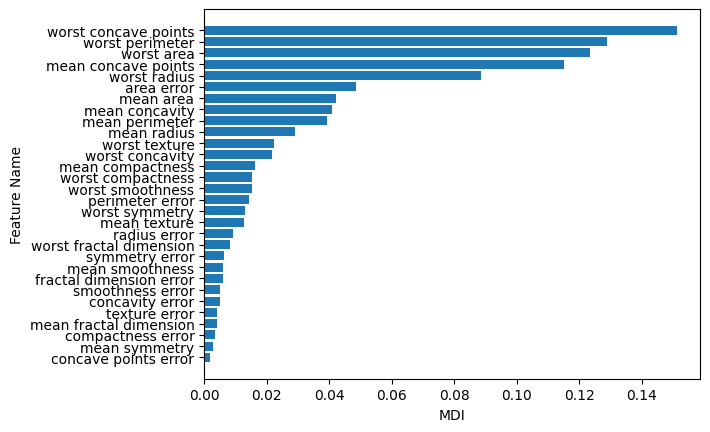

In [6]:
plt.barh(
    list(importances.keys()), 
    importances.values(), 
)
plt.ylabel("Feature Name")
plt.xlabel("MDI");

This evaluation metric gives importance to features that are at higher levels in the overal random forest. Since these features are first considered to split the data they have higher impact in the predictability of the training set. <br>

For this dataset, the features that have higher impact can be seen in the plot above. They are the ones with the higher values, such as **worst perimeter**, **worst concave points** and **worst radius**.

[comment]: <> (Derive from training set. May get bias from high cardinality class)

### Permutation Importance (PI)

In [7]:
rf = RandomForestClassifier(random_state=123).fit(X_train, y_train)
rf.score(X_test, y_test)

0.9649122807017544

<Axes: title={'center': 'Permutation Score for the Test set'}, xlabel='Decrease in mfcc score', ylabel='Feature Name'>

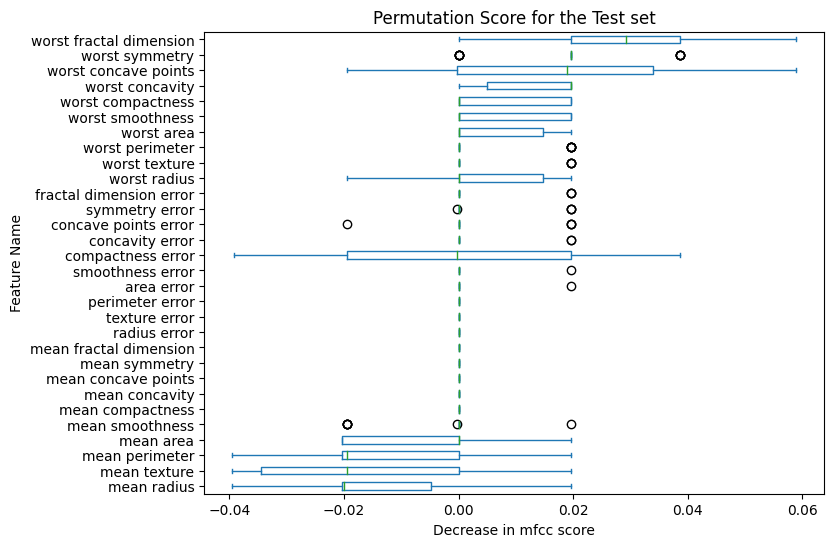

In [8]:
results = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=123, scoring="matthews_corrcoef", n_jobs=2)
idx = results.importances_mean.argsort()
test_perm_importances = pd.DataFrame(
    results.importances[idx].T,
    columns=rf.feature_names_in_
)
test_perm_importances.plot.box(vert=False, whis=10, xlabel="Decrease in mfcc score", ylabel="Feature Name", figsize=(8,6), title="Permutation Score for the Test set")

<Axes: title={'center': 'Permutation Score for the Train set'}, xlabel='Decrease in mfcc score', ylabel='Feature Name'>

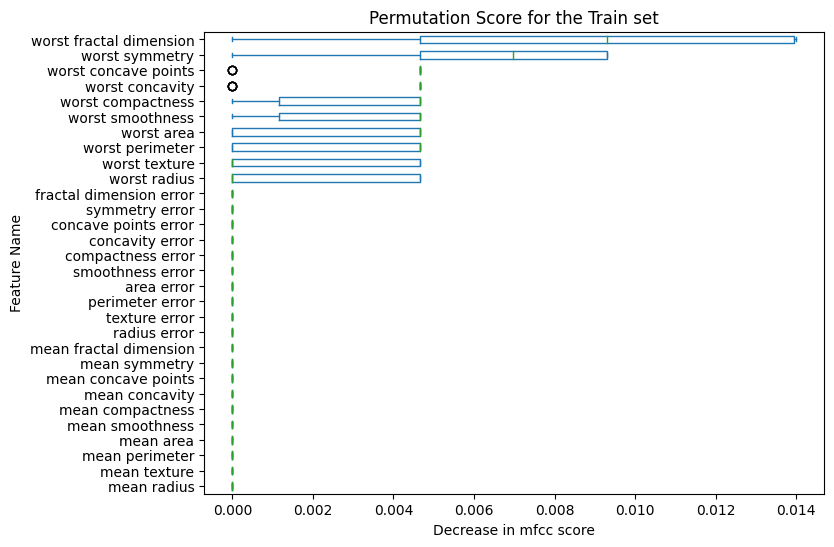

In [9]:
results = permutation_importance(rf, X_train, y_train, n_repeats=30, random_state=123, n_jobs=2, scoring="matthews_corrcoef")
idx = results.importances_mean.argsort()
train_perm_importances = pd.DataFrame(
    results.importances[idx].T,
    columns=rf.feature_names_in_
)
train_perm_importances.plot.box(vert=False, whis=10, xlabel="Decrease in mfcc score", ylabel="Feature Name", figsize=(8,6), title="Permutation Score for the Train set")

In [10]:
(test_perm_importances.columns==train_perm_importances.columns).all()

True

This measure, unlike the *MDI* can be computed on a dataset different from the training set. In the previous plots we can see a plot with the *permutation score* for both the training and the testing set. <br>

This measures indicates how much the performance of the model is worsen by removing one of the features. Therefore higher values implicate a higher impact, and therefore a higher importance for that feature.

In the previous plots we can see that there are no differences in the feature importance ranking order for the training or the test set. The three most important features are **worst fractal dimension**, **worst symmetry** and **worst concave points**.

### Compare MDI with PI

In [11]:
min(importances.values()), max(importances.values())

(0.0017806562953420716, 0.1510456722429861)

In [12]:
importances = pd.DataFrame(data = list(importances.values()), index=importances.keys())

In [13]:
mdi_perm_importances = pd.concat((importances, train_perm_importances.mean()), axis=1)
mdi_perm_importances.columns = ["MDI", "Perm."]

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
mdi_perm_importances[:] = MinMaxScaler().fit_transform(mdi_perm_importances)

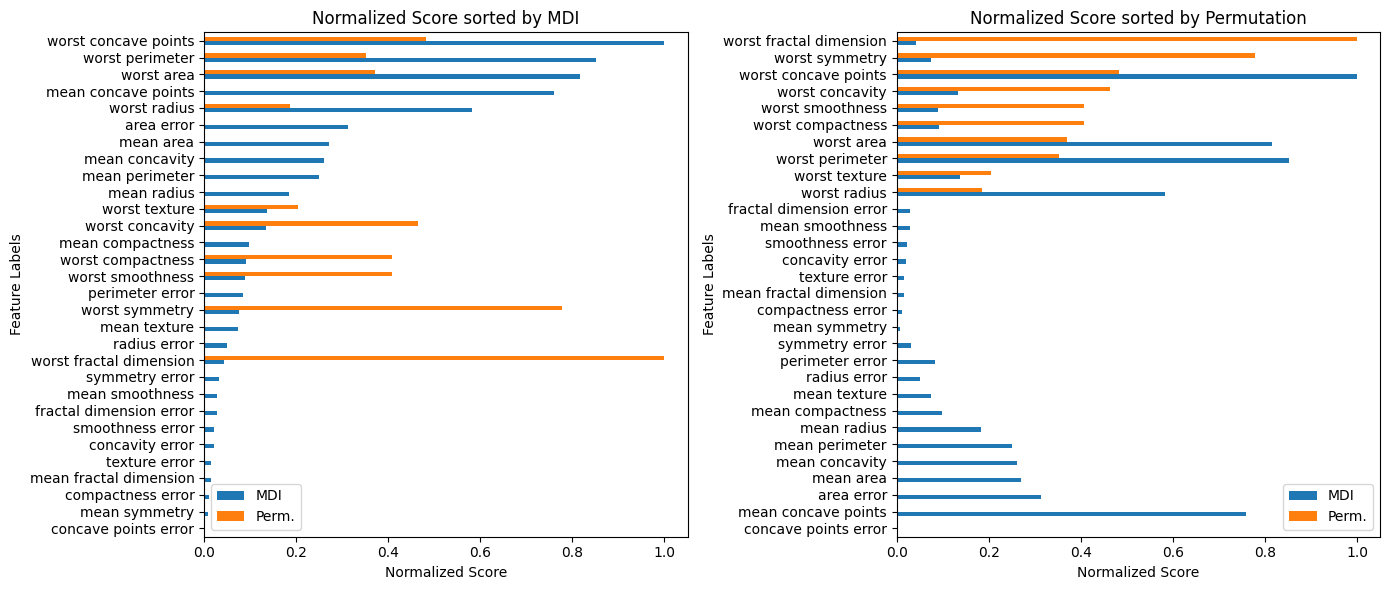

In [16]:
f, ax = plt.subplots(1,2,figsize=(14,6))
mdi_perm_importances.sort_values(by="MDI").plot.barh(
    ax=ax[0],
    title="Normalized Score sorted by MDI",
    ylabel="Feature Labels",
    xlabel="Normalized Score"
)
mdi_perm_importances.sort_values(by="Perm.").plot.barh(
    ax=ax[1],
    title="Normalized Score sorted by Permutation",
    ylabel="Feature Labels",
    xlabel="Normalized Score"
)
f.tight_layout()

We can see big differences between both statistic measures. The features with higher permutation score have a very low MDI score. Reversing, we can see that some of the features with high MDI have a relative high ranking in the Permutation score. <br>

As it is indicated in the sklearn documentation, MDI score suffers from both features with high cardinality and overfitting, while permutation score is more robust and can give a more accurate score for this situtations.

### Explanability using **SHAP**

In [17]:
import shap
from shap import TreeExplainer

In [18]:
shap.initjs()

In [19]:
explainer = TreeExplainer(rf)

In [20]:
shap_values = explainer.shap_values(X_test)

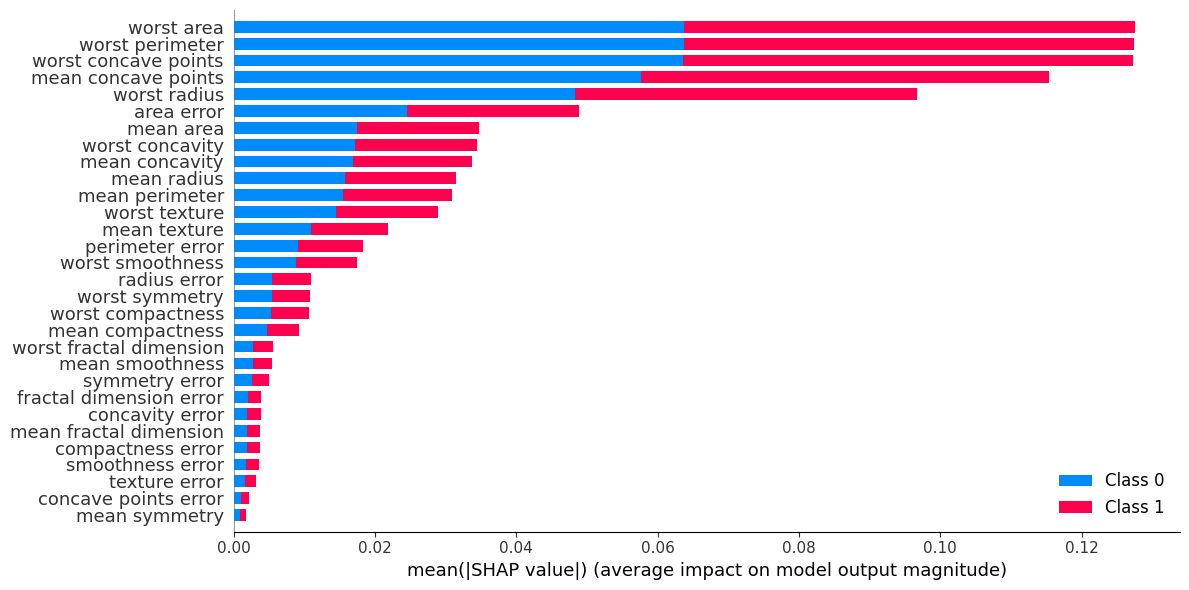

In [21]:
shap.summary_plot(shap_values, X_test, plot_size=(12,6), max_display=30)

In [22]:
shap_values[0].shape

(114, 30)

Similarly to the tutorial, all the features seem to contribute equally for both classes, and the features that contributes the most are the **worst area**, **worst perimeter** and **worst concave points**.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


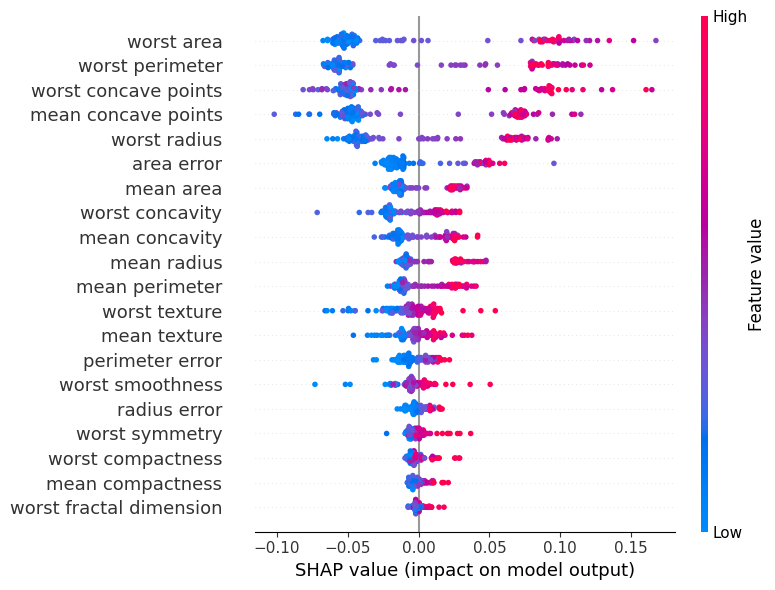

In [23]:
shap.summary_plot(shap_values[0], X_test, plot_size=(8,6));

We can see that for the "negative class" the features that contribute the most are **worst area**, **worst perimeter** and **worst concave points**. For all of this features with the most impact, as well as most of the other features we see that higher values have a positive impact on the outcome of the model. This is, having a high value for those variables increases the probability of predicting the class $0$

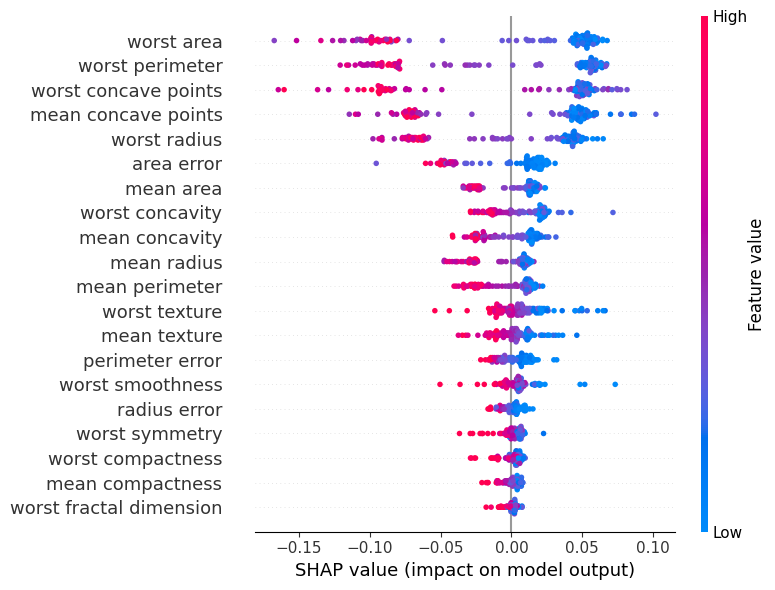

In [24]:
shap.summary_plot(shap_values[1], X_test, plot_size=(8,6));

For the positive class, we can see almost a reverse plot from the previous one. So the conclusions are pretty much the inverse of the negative class, since this is a binary problem. So if the probability of the class $0$ lowers, the probability of the positive class gets higher.

### Explainability Using **Lime**

In [25]:
from lime.lime_tabular import LimeTabularExplainer

In [26]:
class_names = ["No Breast Cancer", "Has Breast Cancer"]

In [27]:
feat_names = list(X_train.columns)

In [28]:
exp = LimeTabularExplainer(X_train.values, feature_names=feat_names, 
                          class_names=class_names, mode="classification")

In [29]:
exp.explain_instance(X_test.iloc[1], rf.predict_proba).show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


We can see that for the particular instance indexed as row #1, The model predicts that the patient has breast cancer with 61% confidence. This is due to multiple factors, but mainly because of the features **worst texture**, **mean texture** and **worst concavity**. 

# Problem 2

## Lime

In [30]:
import os
import numpy as np
import matplotlib.image as mpimg

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks

import tensorflow as tf

In [31]:
dir_ = os.path.join("./animals/")

In [32]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  validation_split = 0.2)


train_generator = train_datagen.flow_from_directory(dir_,target_size=(100, 100),
                                                   batch_size= 500,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset = 'training')

test_generator = train_datagen.flow_from_directory(dir_,
                                                          target_size = (100,100),
                                                          batch_size = 480,
                                                          class_mode = 'categorical',
                                                          shuffle=False,
                                                          subset = 'validation')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [33]:
model = Sequential([
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    # Output neuron. 
        Dense(3, activation='softmax') 
])

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit(
    train_generator,  
    epochs=30,
    verbose=1,
    validation_data=test_generator
)

In [36]:
model = tf.keras.models.load_model("cnn")

In [37]:
import skimage
from tensorflow.keras.preprocessing import image

url = 'https://raw.githubusercontent.com/marcellusruben/All_things_medium/main/Lime/panda_00024.jpg'

def read_and_transform_img(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (100,100))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

In [38]:
images = read_and_transform_img(url)

preds = model.predict(images/255)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
elif prediction == 1:
    print('It\'s a dog!')
else:
    print('It\'s a panda!')

print(pct)

1/1 [==============================] - 2s 2s/step
It's a panda!
0.8756388


In [39]:
from lime import lime_image

In [40]:
exp = lime_image.LimeImageExplainer()

In [41]:
images.shape

(1, 100, 100, 3)

In [42]:
explanation = exp.explain_instance(images[0].astype("double"), model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


In [43]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

(-0.5, 99.5, 99.5, -0.5)

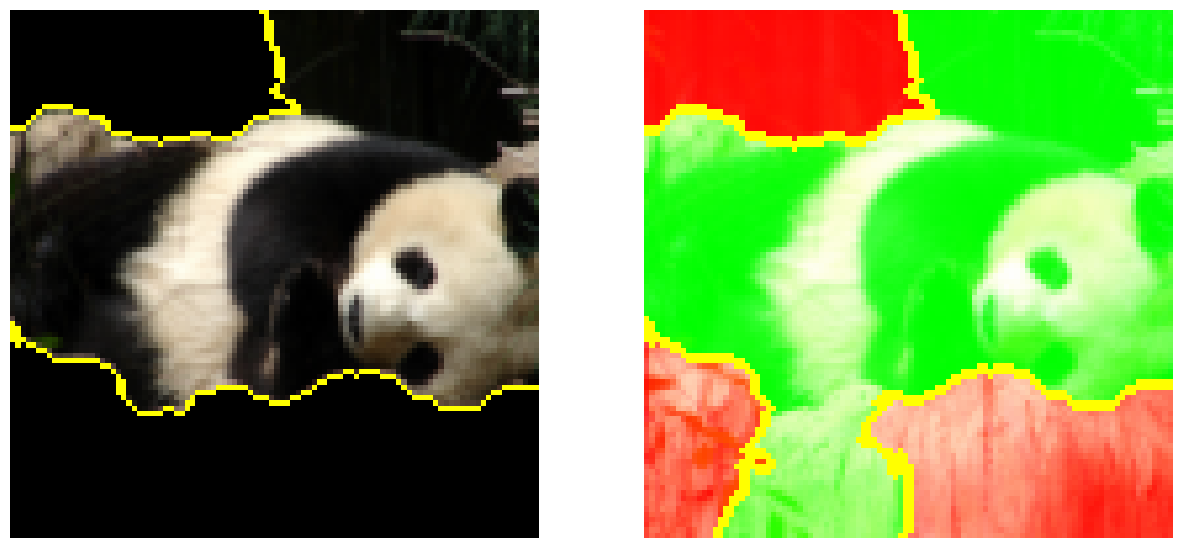

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(skimage.segmentation.mark_boundaries(temp_1, mask_1))
ax2.imshow(skimage.segmentation.mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [45]:
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def transform_img_fn_ori(url):
    
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    #img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

inet_model = inc_net.InceptionV3()
images_inc_im = transform_img_fn_ori(url)

1/1 [==============================] - 3s 3s/step
('n02510455', 'giant_panda', 0.92134047)
('n04266014', 'space_shuttle', 0.0039225942)
('n02002556', 'white_stork', 0.000787556)
('n04254680', 'soccer_ball', 0.0007359236)
('n02509815', 'lesser_panda', 0.0007290899)


In [46]:
explanation= exp.explain_instance(images_inc_im[0].astype('double'), inet_model.predict,  top_labels=3, hide_color=0, num_samples=1000)
 
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


(-0.5, 298.5, 298.5, -0.5)

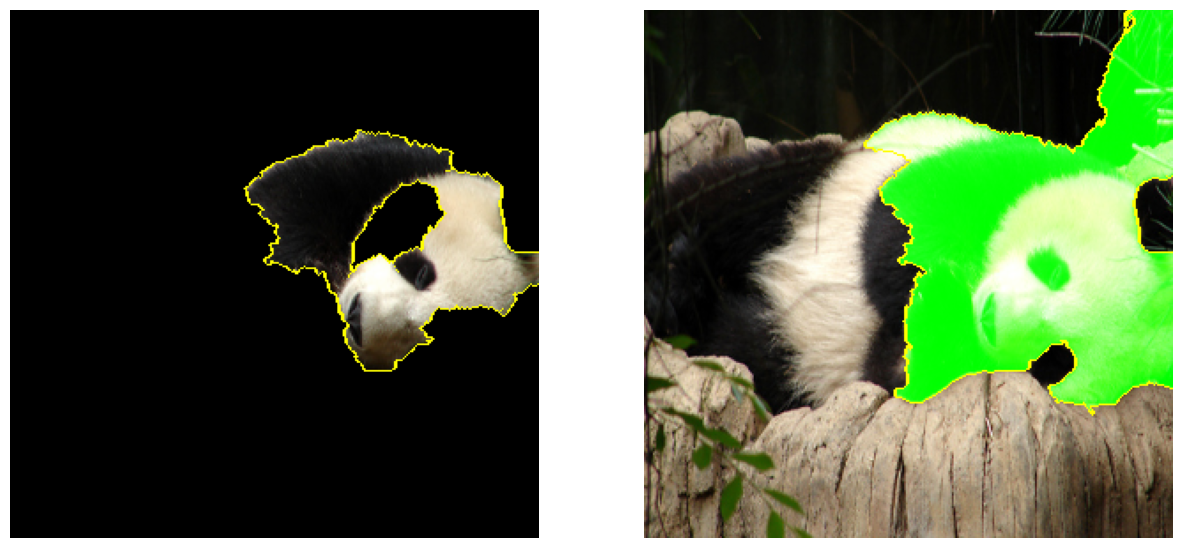

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(skimage.segmentation.mark_boundaries(temp_1, mask_1))
ax2.imshow(skimage.segmentation.mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

## Shap

In [48]:
train_images = next(train_generator)

In [49]:
np.unique(
    np.where(train_images[1]==1)[1], return_counts=True
)

(array([0, 1, 2], dtype=int64), array([153, 175, 172], dtype=int64))

In [50]:
model.trainable=False

In [51]:
for i in range(len(model.layers)):
    model.layers[i].trainable=False

In [52]:
images[0].shape

(100, 100, 3)

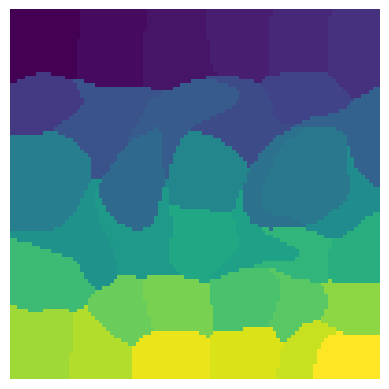

In [53]:
from skimage.segmentation import slic
from keras.applications.vgg16 import preprocess_input 
segments_slic = slic(images[0], n_segments=30, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.axis('off');

In [54]:
label = {"cat":0, "dog":1,"panda":2}
rev_label = {it[1]:it[0] for it in label.items()}

In [55]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, images[0], 255)))

In [56]:
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 1s 9ms/step


In [57]:
preds = model.predict(preprocess_input(np.expand_dims(images[0].copy(), axis=0)))
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_10_pred=pd.Series(data=[preds[0, inds[i]] for i in range(3)])

1/1 [==============================] - 0s 36ms/step


In [58]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out


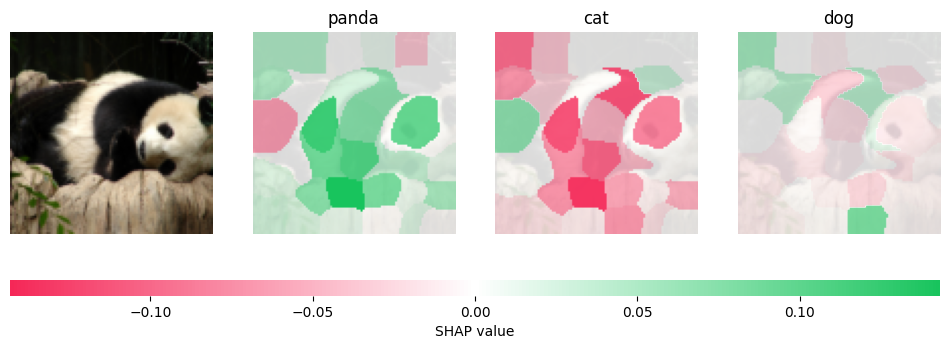

In [59]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(images[0])
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].imshow(images[0], alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
    axes[i+1].set_title(rev_label[inds[i]])
    
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

From the plot above we can also see which areas contribute the most to the classification of the image as a '*panda*'. Not only that, but which areas contribute to the classification of another class. <br>
However, the Lime model segmented the part of the image that contributed to the classification of the image in a way that it is more interpretable, as it segmented exacly the most relevant area. Therefore we think that Lime model generated better explanations.